In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta

In [2]:
df1 = pd.read_csv("file_3_Mar18_Output_1.csv")
df2 = pd.read_csv("file_4_Mar18_Output_1.csv")

df_merged = pd.concat([df1, df2], ignore_index=True, sort=False)

Cleaning data: analyze recalls

Goal: remove 'resolved' calls where 'floor' recall occurs within 60 minutes (these types of resolved calls can be considered 'faulty resolved')

In [4]:
# helper functions

# function to take timestamp in "timestamp_call_key" and turn into python date object
def transform_timestamp(row):
    date_string = row["timestamp_call_key"].split()[0]
    year = 2000 + int(date_string[0:2])
    month = int(date_string[2:4])
    day = int(date_string[5:6])
    hour = int(date_string[6:8])
    minute = int(date_string[8:10])
    second = int(date_string[10:12])

    row_date = datetime.datetime(year, month, day, hour, minute, second)
    return row_date


def transform_open_date(row):
  date_string = row["account_open_date_13_march"]
  date_arr = [int(i) for i in date_string.split('/')]
  row_date = datetime.datetime(date_arr[2], date_arr[0], date_arr[1])
  return row_date

In [5]:
df_merged["date_account_opened"] = df_merged.apply(transform_open_date, axis=1)
df_merged["call_timestamp"] = df_merged.apply(transform_timestamp, axis=1)
df_merged = df_merged.drop(columns=["account_balance_13_march", "account_balance_18_march"])

In [6]:
df_merged['call_date'] = df_merged['call_timestamp'].dt.date
df_merged['call_time'] = df_merged['call_timestamp'].dt.strftime('%H:%M:%S')
df_merged.head()

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,delinquency_history_13_march,account_open_date_13_march,account_status_13_march,...,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march,date_account_opened,call_timestamp,call_date,call_time
0,240315173250 DAL1OA3M,D,10010009499,PP,IA PP TR,resolved,1.0,[00],5/19/2013,NaN,...,5/19/2013,NaN,0,1,E,0,2013-05-19,2024-03-05 17:32:50,2024-03-05,17:32:50
1,240315124742 DAL15XHK,E,10006021998,BA,IA BA TS nl TR,floor,2.0,[00],9/22/2003,NaN,...,9/22/2003,NaN,0,1,E,0,2003-09-22,2024-03-05 12:47:42,2024-03-05,12:47:42
2,240317114237 DAL3BLK6,J,10016007830,PT,IA AA BA MR nl PT TR,resolved,12.0,[00],9/4/2017,NaN,...,9/4/2017,NaN,8,0,,0,2017-09-04,2024-03-07 11:42:37,2024-03-07,11:42:37
3,240314120849 PHX6PL4U,E,10008003199,BA,IA BA,resolved,2.0,[00],2/7/2024,NaN,...,2/7/2024,NaN,0,0,L,0,2024-02-07,2024-03-04 12:08:49,2024-03-04,12:08:49
4,240314145902 DAL68RYS,I,10013002037,BA,IA BA TS nl mm TR,floor,6.0,[00],1/2/2022,NaN,...,1/2/2022,NaN,0,1,,0,2022-01-02,2024-03-04 14:59:02,2024-03-04,14:59:02


In [7]:
filtered_df = df_merged[df_merged.duplicated(subset=['serial', 'call_date'], keep=False)]

# grouped_df = filtered_df.groupby(['serial', 'call_date']).agg({'call_timestamp': lambda x: list(x), 
#                                                                'reason': lambda x: list(x), 
#                                                                'resolved': lambda x: list(x)}).reset_index(),

grouped_df = filtered_df.groupby(['serial', 'call_date']).agg({'timestamp_call_key': lambda x: list(x),
                                                               'call_timestamp': lambda x: list(x), 
                                                               'reason': lambda x: list(x), 
                                                               'resolved': lambda x: list(x)}).reset_index(),
                                                               

grouped_df[0].head()

,serial,call_date,timestamp_call_key,call_timestamp,reason,resolved
0,10001000001,2024-03-06,"[240316112732 DAL7PM38, 240316122342 PHX1H82J,...","[2024-03-06 11:27:32, 2024-03-06 12:23:42, 202...","[BA, mp, mp, PT]","[resolved, resolved, resolved, resolved]"
1,10001000002,2024-03-04,"[240314000933 PHX2ILKM, 240314001731 PHX1UIW6,...","[2024-03-04 00:09:33, 2024-03-04 00:17:31, 202...","[FD, FD, BA]","[floor, floor, floor]"
2,10001000012,2024-03-06,"[240316003837 PHX3OB67, 240316231422 DAL1OE53]","[2024-03-06 00:38:37, 2024-03-06 23:14:22]","[BA, BA]","[resolved, resolved]"
3,10001000015,2024-03-04,"[240314000008 PHX5X66J, 240314224244 DAL4H4DC]","[2024-03-04 00:00:08, 2024-03-04 22:42:44]","[FD, FD]","[floor, floor]"
4,10001000023,2024-03-04,"[240314000102 DAL4PVYT, 240314102718 DAL5TTXF,...","[2024-03-04 00:01:02, 2024-03-04 10:27:18, 202...","[BA, BA, BA]","[resolved, floor, floor]"


In [8]:
# Function to check if two timestamps are within 60 minutes
def within_60_minutes(timestamp1, timestamp2):
    return abs((timestamp1 - timestamp2).total_seconds()) <= 3600

# Initialize a dictionary to store timestamp_call_keys
faulty_resolved = set()

# Iterate over each row in grouped_df
for _, row in grouped_df[0].iterrows():
    resolved_indices = set()  # Store indices of resolved calls within 60 minutes
    floor_indices = set()     # Store indices of floor calls within 60 minutes
    
    # Iterate over each timestamp_call_key and call_timestamp pair
    for timestamp_call_key, call_timestamp in zip(row['timestamp_call_key'], row['call_timestamp']):
        # Check if the call is resolved
        if row['resolved'][row['call_timestamp'].index(call_timestamp)] == 'resolved':
            # Check if there are subsequent calls within 60 minutes
            for next_timestamp_call_key, next_call_timestamp in zip(row['timestamp_call_key'], row['call_timestamp']):
                if (next_timestamp_call_key != timestamp_call_key and
                    within_60_minutes(call_timestamp, next_call_timestamp)):
                    if row['resolved'][row['call_timestamp'].index(next_call_timestamp)] == 'floor':
                        floor_indices.add(next_timestamp_call_key)
                    resolved_indices.add(timestamp_call_key)
    
    # Add resolved call timestamp_call_keys to the list
    faulty_resolved.update(resolved_indices)

# Now timestamp_call_keys_df contains serial, call_date, and related_resolved_calls lists

In [9]:
len(faulty_resolved)

212940

In [10]:
removed_faulty_resolved_df = df_merged[~df_merged['timestamp_call_key'].isin(faulty_resolved)]

removed_faulty_resolved_df


,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,delinquency_history_13_march,account_open_date_13_march,account_status_13_march,...,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march,date_account_opened,call_timestamp,call_date,call_time
0,240315173250 DAL1OA3M,D,10010009499,PP,IA PP TR,resolved,1.0,[00],5/19/2013,NaN,...,5/19/2013,NaN,0,1,E,0,2013-05-19,2024-03-05 17:32:50,2024-03-05,17:32:50
1,240315124742 DAL15XHK,E,10006021998,BA,IA BA TS nl TR,floor,2.0,[00],9/22/2003,NaN,...,9/22/2003,NaN,0,1,E,0,2003-09-22,2024-03-05 12:47:42,2024-03-05,12:47:42
2,240317114237 DAL3BLK6,J,10016007830,PT,IA AA BA MR nl PT TR,resolved,12.0,[00],9/4/2017,NaN,...,9/4/2017,NaN,8,0,,0,2017-09-04,2024-03-07 11:42:37,2024-03-07,11:42:37
3,240314120849 PHX6PL4U,E,10008003199,BA,IA BA,resolved,2.0,[00],2/7/2024,NaN,...,2/7/2024,NaN,0,0,L,0,2024-02-07,2024-03-04 12:08:49,2024-03-04,12:08:49
4,240314145902 DAL68RYS,I,10013002037,BA,IA BA TS nl mm TR,floor,6.0,[00],1/2/2022,NaN,...,1/2/2022,NaN,0,1,,0,2022-01-02,2024-03-04 14:59:02,2024-03-04,14:59:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798790,240314191841 DAL27M1P,i,20012004106,PP,IA PP TR,resolved,4.0,[00],9/19/2021,NaN,...,9/19/2021,NaN,0,0,,0,2021-09-19,2024-03-04 19:18:41,2024-03-04,19:18:41
1798792,240314080117 DAL3CVDQ,b,20002002187,BA,mn IA PP BA MR nl WA nl BA nl mt,floor,9.0,[00],12/19/2023,NaN,...,12/19/2023,NaN,0,0,NaN,0,2023-12-19,2024-03-04 08:01:17,2024-03-04,08:01:17
1798795,240316190932 PHX2S13U,a,20001160188,PP,IA PP TR,resolved,7.0,[00],8/24/2023,NaN,...,8/24/2023,NaN,0,0,,0,2023-08-24,2024-03-06 19:09:32,2024-03-06,19:09:32
1798796,240317213341 PHX35A2C,d,20010020211,FD,IA IA TR,floor,8.0,[00],5/15/2019,A,...,5/15/2019,A,0,1,L,0,2019-05-15,2024-03-07 21:33:41,2024-03-07,21:33:41


In [11]:
removed_faulty_resolved_df.to_csv("removed_faulty_resolved", index=False)

In [12]:
only_faulty_resolved_df = df_merged[df_merged['timestamp_call_key'].isin(faulty_resolved)]
only_faulty_resolved_df

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,delinquency_history_13_march,account_open_date_13_march,account_status_13_march,...,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march,date_account_opened,call_timestamp,call_date,call_time
7,240316171347 PHX4I164,B,10002094529,BA,IA BA,resolved,6.0,[00],9/13/2020,NaN,...,9/13/2020,NaN,0,0,,0,2020-09-13,2024-03-06 17:13:47,2024-03-06,17:13:47
8,240316171945 DAL16OYM,B,10002094529,BA,IA IA IA BA,resolved,6.0,[00],9/13/2020,NaN,...,9/13/2020,NaN,0,0,,0,2020-09-13,2024-03-06 17:19:45,2024-03-06,17:19:45
20,240314114650 DAL6K9K1,B,10002010726,PP,IA PP TR,resolved,3.0,[03],8/26/2021,NaN,...,8/26/2021,NaN,0,1,,0,2021-08-26,2024-03-04 11:46:50,2024-03-04,11:46:50
21,240314115040 PHX4BTO7,B,10002010726,PP,IA PP TR,resolved,3.0,[03],8/26/2021,NaN,...,8/26/2021,NaN,0,1,,0,2021-08-26,2024-03-04 11:50:40,2024-03-04,11:50:40
40,240315134622 DAL6DHIV,I,10013005305,PT,IA BA MR nl PT TR,resolved,5.0,[00],12/29/2023,NaN,...,12/29/2023,NaN,0,0,,0,2023-12-29,2024-03-05 13:46:22,2024-03-05,13:46:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798786,240315101627 PHX3KB6V,f,20006017345,PP,IA PP TR,resolved,3.0,[00],8/16/2023,NaN,...,8/16/2023,NaN,0,0,,0,2023-08-16,2024-03-05 10:16:27,2024-03-05,10:16:27
1798787,240315101845 PHX3VAJ9,f,20006017345,PP,IA PP TR,resolved,3.0,[00],8/16/2023,NaN,...,8/16/2023,NaN,0,0,,0,2023-08-16,2024-03-05 10:18:45,2024-03-05,10:18:45
1798791,240314075300 PHX5SRLR,b,20002002187,PP,mn IA PP TR,resolved,9.0,[00],12/19/2023,NaN,...,12/19/2023,NaN,0,0,NaN,0,2023-12-19,2024-03-04 07:53:00,2024-03-04,07:53:00
1798793,240314120118 DAL2JPAQ,i,20012001463,BA,IA BA TA nl,resolved,14.0,[00],2/8/2022,NaN,...,2/8/2022,NaN,0,0,,0,2022-02-08,2024-03-04 12:01:18,2024-03-04,12:01:18


In [13]:
only_faulty_resolved_df.to_csv("only_faulty_resolved", index=False)

Analyzing Promotional Balance reason (Pd)

Goal: see if Pd calls drastically differs from rest of dataset for a specific attribute (like retailer codes)

In [16]:
df_merged = pd.read_csv("removed_faulty_resolved")

In [17]:
pd_df = df_merged.loc[df_merged['reason'] == 'Pd']
no_pd_df = df_merged.loc[df_merged['reason'] != 'Pd']


In [18]:
prob_df = pd_df['retailer_code'].value_counts().reset_index()
prob_df = prob_df.rename(columns={'count': 'pd_count'})

prob_df['Pd Prob.'] = prob_df['pd_count'].apply(lambda x : x / pd_df.shape[0])

prob_df2 = no_pd_df['retailer_code'].value_counts().reset_index()
prob_df2 = prob_df2[prob_df2['retailer_code'].isin(prob_df['retailer_code'])]

prob_df2 = prob_df2.rename(columns={'count': 'no_pd_count'})

prob_df2['Not Pd Prob.'] = prob_df2['no_pd_count'].apply(lambda x : x / no_pd_df.shape[0])
prob_df2['relative_no_pd_prob'] = prob_df2['Not Pd Prob.'].apply(lambda x : x / prob_df2['Not Pd Prob.'].sum())

relative_prob_df = prob_df2[['retailer_code','Not Pd Prob.']]

merged_prob_df = prob_df.merge(relative_prob_df, how='left', on='retailer_code')

merged_prob_df


,retailer_code,pd_count,Pd Prob.,Not Pd Prob.
0,a,6024,0.934678,0.127724
1,c,315,0.048875,0.048203
2,D,75,0.011637,0.095832
3,F,31,0.004810,0.012452


(array([0, 1, 2, 3]),
 [Text(0, 0, 'a'), Text(1, 0, 'c'), Text(2, 0, 'D'), Text(3, 0, 'F')])

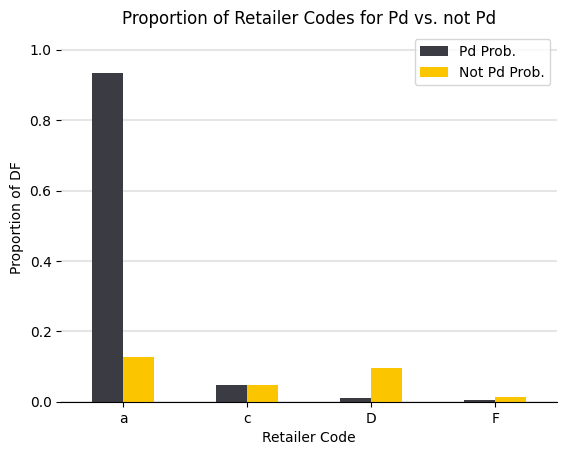

In [20]:
merged_prob_plot_df = merged_prob_df[['retailer_code', 'Pd Prob.', 'Not Pd Prob.']].set_index('retailer_code')
merged_prob_plot_df.plot.bar()

plt.ylabel("Proportion of DF")
plt.xlabel("Retailer Code")
plt.title("Proportion of Retailer Codes for Pd vs. not Pd")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Get the yticks and corresponding yticklabels
yticks = plt.yticks()[0]
yticklabels = plt.yticks()[1]

# Plot horizontal lines corresponding to the yticks behind the bars
for ytick, yticklabel in zip(yticks, yticklabels):
    plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.2, zorder=0)  # Add horizontal line

        
SYNCHRONY_COLORS = ['#3B3C43', "#FBC600", "#3E8529"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=SYNCHRONY_COLORS)

plt.legend(loc='upper right')

plt.xticks(rotation=0)



Analyzing Proactive callers

In [23]:
df1 = pd.read_csv("file_3_Mar18_Output_1.csv")
df2 = pd.read_csv("file_4_Mar18_Output_1.csv")

df_merged = pd.concat([df1, df2], ignore_index=True, sort=False)

In [27]:
negative_codes = {"DP", "CT", "FD", "FM", "wa", "WA", "LS", "RC"}
negative_situations = {
    "DP" : "Disputes",
    "CT" : "Change in Terms", 
    "FD" : "Fraud",
    "FM" : "Fraud",
    "wa" : "Late Fee Waiver",
    "WA" : "Late Fee Waiver",
    "LS" : "Lost/Stolen/Replacement",
    "RC" : "Lost/Stolen/Replacement"
}
negative_overlap = {
    "wa" : "WA",
    "LS" : "RC",
    "FM" : "FD"
}

positive_codes = {"IC", "AA", "CA", "BA", "PT", "PP", "mP", "Pd", "AP", "AT"}
positive_situations = {
    "IC" : "Credit Increase",
    "AA" : "Account Activation",
    "CA" : "Close Account",
    "BA" : "Account Summary",
    "PT" : "Pay-By-Phone",
    "PP" : "Pay-By-Phone",
    "AT" : "Account Transactions",

    "mp" : "Payment Menu",
    "Pd" : "Promotional Balance",
    "AP" : "Address/Phone Change"
}
positive_overlap = {
    "PP" : "PT"
}

def format_reason_df_pos_neg(df, count_restraint, isPositive):
    # aggregate rid of overlapping codes
    overlap_obj = positive_overlap if isPositive else negative_overlap 
    situation_obj = positive_situations if isPositive else negative_situations
    df["Code"] = df["reason"].apply(lambda x : overlap_obj[x] if x in overlap_obj else x)

    reason_crosstab = pd.crosstab(df["Code"], df["resolved"], normalize='index')

    reason_counts = df["Code"].value_counts()
    reason_crosstab = reason_crosstab.merge(reason_counts, how="left", on="Code").reset_index()

    reason_crosstab = reason_crosstab.sort_values(by=["floor"], ascending=False)
    reason_crosstab = reason_crosstab[reason_crosstab["count"] > count_restraint] 
    if isPositive:
        reason_crosstab = reason_crosstab[reason_crosstab["Code"].isin(positive_codes)]
    else:
        reason_crosstab = reason_crosstab[reason_crosstab["Code"].isin(negative_codes)]

    reason_crosstab["English Description"] = reason_crosstab["Code"].apply(lambda x: situation_obj[x])   
    reason_crosstab = reason_crosstab.set_index(["Code"])
    return reason_crosstab

pos_reason_df = format_reason_df_pos_neg(df_merged, 4000, True)
neg_reason_df = format_reason_df_pos_neg(df_merged, 4000, False)


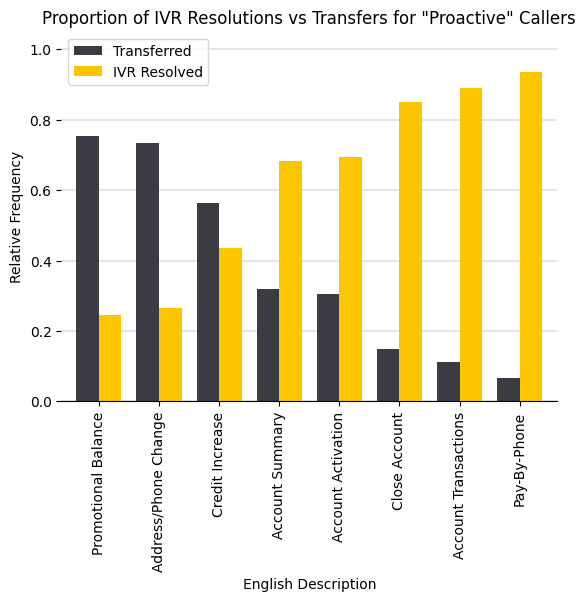

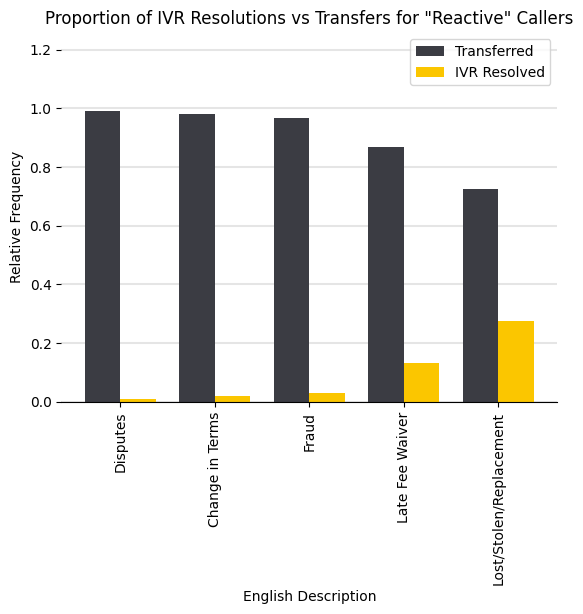

In [28]:
def format_for_plot(df):
    df = df.set_index("English Description").drop(columns="count")
    df["Transferred"] = df["floor"]
    df["IVR Resolved"] = df["resolved"]
    df.sort_values("IVR Resolved")
    df = df.drop(columns=["floor", "resolved"])
    return df

def plot_transfer_v_IVR(df, title):
    format_for_plot(df).plot.bar(width = 0.75)
    plt.ylabel("Relative Frequency")
    plt.title(title)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Get the yticks and corresponding yticklabels
    yticks = plt.yticks()[0]
    yticklabels = plt.yticks()[1]

    # Plot horizontal lines corresponding to the yticks behind the bars
    for ytick, yticklabel in zip(yticks, yticklabels):
        plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.2, zorder=0)  # Add horizontal line

SYNCHRONY_COLORS = ['#3B3C43', "#FBC600", "#3E8529"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=SYNCHRONY_COLORS)

plot_transfer_v_IVR(pos_reason_df, "Proportion of IVR Resolutions vs Transfers for \"Proactive\" Callers")
plot_transfer_v_IVR(neg_reason_df, "Proportion of IVR Resolutions vs Transfers for \"Reactive\" Callers")


In [29]:
# grab rows where "reason -> Address/phone change"
ap_df = df_merged[df_merged["reason"] == "AP"]
# grab rows where "reason !-> Address/phone change"
non_ap_df = df_merged[df_merged["reason"] != "AP"]
# goal: compare these two to see any two significant changes

In [30]:
def parse_year(row):
    date_string = row["account_open_date_18_march"]
    if (date_string == np.nan):
        return "INVALID"
    year_string = date_string[len(date_string) - 4:len(date_string)]
    #print(year_string)
    return year_string
ap_df["account_open_year"] = ap_df.apply(parse_year, axis=1)
ap_df["account_open_year"].value_counts()
non_ap_df["account_open_year"] = non_ap_df.apply(parse_year, axis=1)
ap_df = ap_df.drop(columns=["account_open_date_18_march", "account_open_date_13_march"])
non_ap_df = non_ap_df.drop(columns=["account_open_date_18_march", "account_open_date_13_march"])

/var/folders/tn/zr4zvmv11n1b3xnlpyw95t5w0000gn/T/ipykernel_60437/3779166019.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_df["account_open_year"] = ap_df.apply(parse_year, axis=1)
/var/folders/tn/zr4zvmv11n1b3xnlpyw95t5w0000gn/T/ipykernel_60437/3779166019.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ap_df["account_open_year"] = non_ap_df.apply(parse_year, axis=1)


           AP_Callers  Non_AP_Callers
new_index                            
Yes          0.397023        0.334284
No           0.602977        0.665716


Text(0.5, 1.0, 'Proportion of E-Service Enrollment for AP vs Non-AP Callers')

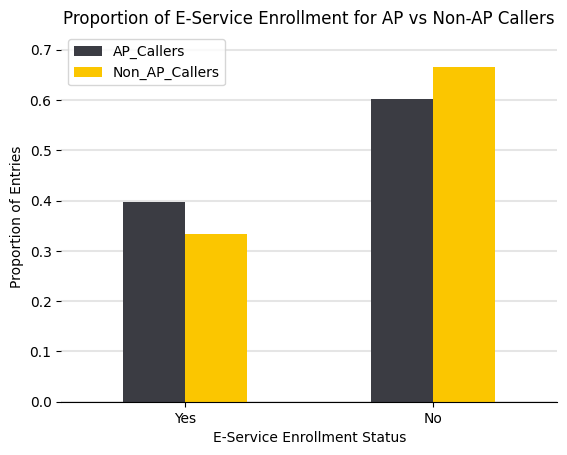

In [31]:
def createProportionDf(small, large, col_name):
    large_counts = large[col_name].value_counts().reset_index()
    large_counts["large_count"] = large_counts["count"]

    large_counts = large_counts.drop(columns="count")
    small_counts = small[col_name].value_counts().reset_index()
    small_counts["small_count"] = small_counts["count"]
    small_counts = small_counts.drop(columns="count")
    total_counts = large_counts.merge(small_counts, how='left', on=col_name)
    total_counts = total_counts.replace(np.nan, 0)

    total_counts["Non_AP_Callers"] = total_counts["large_count"] / large.shape[0]
    total_counts["AP_Callers"] = total_counts["small_count"] / small.shape[0]
    total_counts["relative_error"] = (total_counts["AP_Callers"] - total_counts["Non_AP_Callers"]) / (total_counts["Non_AP_Callers"])
    total_counts = total_counts[(total_counts["Non_AP_Callers"] > 0.01) | (total_counts["AP_Callers"] > 0.01)]
    total_counts = total_counts.sort_values(by=[col_name], ascending = False).set_index(col_name)
    total_counts = total_counts.reset_index()
    if col_name == "eservice_ind_18_march":
        total_counts["new_index"] = total_counts[col_name].apply(lambda x: "Yes" if x == 1 else "No")
        total_counts = total_counts.set_index("new_index")
    total_counts = total_counts[["AP_Callers", "Non_AP_Callers"]]
    print(total_counts)

    return total_counts

# code to plot e-service:
retailer_code_proportions = createProportionDf(ap_df, non_ap_df, "eservice_ind_18_march")
retailer_code_proportions.plot.bar()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Get the yticks and corresponding yticklabels
yticks = plt.yticks()[0]
yticklabels = plt.yticks()[1]

# Plot horizontal lines corresponding to the yticks behind the bars
for ytick, yticklabel in zip(yticks, yticklabels):
    plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.2, zorder=0)  # Add horizontal line
plt.ylabel("Proportion of Entries")
plt.xlabel("E-Service Enrollment Status")
plt.xticks(rotation=0)
plt.title("Proportion of E-Service Enrollment for AP vs Non-AP Callers")

In [32]:
transferred_calls = df_merged[df_merged["resolved"] == "floor"]
transferred_calls = transferred_calls[["reason"]]
transferred_calls_counts = transferred_calls.value_counts().reset_index()
solved_call_counts = transferred_calls_counts[(transferred_calls_counts["reason"] == "Pd") | (transferred_calls_counts["reason"] == "AP")]
PD_transferred_call_count = solved_call_counts.iloc[0]["count"]
AP_transferred_call_count = solved_call_counts.iloc[1]["count"]
total_transferred_call_count = transferred_calls.shape[0]
PD_transferred_call_count
print(AP_transferred_call_count)
print(PD_transferred_call_count)
print(total_transferred_call_count)
print(f"{(AP_transferred_call_count+PD_transferred_call_count) / (total_transferred_call_count)*50}")

print(f"{20000000*0.22*0.013*5}")

4541
4860
366217
1.283528618278234
286000.0
